# Sentiment Analysis to predict stock price direction using Classifier models

## 1. Introduction
A selection of machine learning classifier models will be used to predict whether the next day Adjusted Close price of AstraZeneca stock will increase or decrease based on sentiment analysis of market news articles from 2014-2021 collected by web scraping from [Investing.com](https://uk.investing.com/equities/astrazeneca-news). 

Sentiment Analysis is the use of NLP, text analysis and
computational linguistics to determine subjective information. Instead of building our own lexicon to do this, we will use VADER (Valence Aware Dictionary and sEntiment Reasoner), a pre-trained sentiment analysis model included in the NLTK package. We will also use TextBlob, a simple API built upon NLTK, for common NLP tasks.




## 2. Install/import libraries

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import seaborn as sns
import math
import datetime
import re
import yfinance as yf
import nltk
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from textblob import TextBlob

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 3. Import data

Read article sentiment data collected by web scraping from Investing.com into a DataFrame.



In [4]:
# Show DataFrame of article sentiments data

article_sentiments = pd.read_csv(r'/content/Sentiment Updated.csv') 
article_sentiments

,Unnamed: 0,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
0,0,AZN.L,26-10-2022,AstraZeneca says advanced trial of breast-canc...,AstraZeneca PLC said Wednesday that Capivasert...,https://invst.ly/zbgw-,0.061,0.830,0.109,0.3612
1,1,AZN.L,26-10-2022,Why AstraZeneca (BIDU) Shares Are Trading High...,AstraZeneca Touts Positive Data From Two Exper...,https://invst.ly/zbmyz,0.304,0.497,0.199,-0.2263
2,2,AZN.L,27-10-2022,AstraZeneca's Ultomiris Showed Zero Relapses I...,AstraZeneca's Ultomiris Showed Zero Relapses I...,https://invst.ly/zcazg,0.172,0.828,0.000,-0.4019
3,3,AZN.L,01-11-2022,AstraZenecaâ€™s COVID-19 Vaccine Granted Full ...,AstraZeneca (NASDAQ: AZN) announced on Tuesday...,https://invst.ly/zdy3j,0.053,0.792,0.155,0.9274
4,4,AZN.L,04-11-2022,Why AstraZeneca (AZN) Shares Are Trading Highe...,by\n \n The European Medicines Agency (EMA) ha...,https://invst.ly/zdyt-,0.057,0.806,0.137,0.9524
...,...,...,...,...,...,...,...,...,...,...
328,328,AZN.L,25-09-2020,Exclusive: AstraZeneca gets partial immunity i...,Â© Reuters. FILE PHOTO: Small toy figures are ...,https://uk.investing.com//news/stock-market-ne...,0.099,0.831,0.071,-0.9657
329,329,AZN.L,25-09-2020,Exclusive: AstraZeneca gets partial immunity i...,Â© Reuters. FILE PHOTO: Small toy figures are ...,https://uk.investing.com//news/stock-market-ne...,0.099,0.831,0.071,-0.9657
330,330,AZN.L,25-09-2020,"FTSE 100 pares early gains, set for second str...",Â© Reuters. Traders look at financial informat...,https://uk.investing.com//news/stock-market-ne...,0.069,0.849,0.083,0.7543
331,331,AZN.L,01-10-2020,UPDATE 1-UK Stocks-Factors to watch on Oct. 1 ...,Â© Reuters.\n \n UK100 +2.03% Add to/Remove fr...,https://uk.investing.com//news/stock-market-ne...,0.073,0.900,0.027,-0.9274


In [5]:
# Create copy of DataFrame

article_sentiments_azn = article_sentiments.copy()
article_sentiments_azn.head(5)

,Unnamed: 0,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
0,0,AZN.L,26-10-2022,AstraZeneca says advanced trial of breast-canc...,AstraZeneca PLC said Wednesday that Capivasert...,https://invst.ly/zbgw-,0.061,0.830,0.109,0.3612
1,1,AZN.L,26-10-2022,Why AstraZeneca (BIDU) Shares Are Trading High...,AstraZeneca Touts Positive Data From Two Exper...,https://invst.ly/zbmyz,0.304,0.497,0.199,-0.2263
2,2,AZN.L,27-10-2022,AstraZeneca's Ultomiris Showed Zero Relapses I...,AstraZeneca's Ultomiris Showed Zero Relapses I...,https://invst.ly/zcazg,0.172,0.828,0.000,-0.4019
3,3,AZN.L,01-11-2022,AstraZenecaâ€™s COVID-19 Vaccine Granted Full ...,AstraZeneca (NASDAQ: AZN) announced on Tuesday...,https://invst.ly/zdy3j,0.053,0.792,0.155,0.9274
4,4,AZN.L,04-11-2022,Why AstraZeneca (AZN) Shares Are Trading Highe...,by\n \n The European Medicines Agency (EMA) ha...,https://invst.ly/zdyt-,0.057,0.806,0.137,0.9524


## 4. Clean news data

Prepare data for further processing by appending separator to body text of each article.

In [6]:
# Append ---newarticle--- to split for NLP

article_sentiments_azn['body_text'] = article_sentiments_azn['body_text'].astype(str) + '---newarticle---'

In [7]:
azn_bodytext = article_sentiments_azn['body_text']
azn_bodytext

0      AstraZeneca PLC said Wednesday that Capivasert...
1      AstraZeneca Touts Positive Data From Two Exper...
2      AstraZeneca's Ultomiris Showed Zero Relapses I...
3      AstraZeneca (NASDAQ: AZN) announced on Tuesday...
4      by\n \n The European Medicines Agency (EMA) ha...
                             ...                        
328    Â© Reuters. FILE PHOTO: Small toy figures are ...
329    Â© Reuters. FILE PHOTO: Small toy figures are ...
330    Â© Reuters. Traders look at financial informat...
331    Â© Reuters.\n \n UK100 +2.03% Add to/Remove fr...
332    Â© Reuters.\n \n UK100 +2.03% Add to/Remove fr...
Name: body_text, Length: 333, dtype: object

In [8]:
pd.set_option("display.max_colwidth", -1)  # to display full text
azn_bodytext

0      AstraZeneca PLC said Wednesday that Capivasertib plus Faslodex significantly improved progression-free survival when compared with Faslodex combined with a placebo in a Phase 3 trial in advanced hormone receptor-positive breast cancer.\n \n The Anglo-Swedish pharma giant AZN, +1.77% AZN, +0.56% said the trial met both primary endpoints of improving progression-free survival in the overall patient population and in a prespecified biomarker subgroup of patients whose tumors had qualifying alterations.---newarticle---                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [9]:
# Save article_sentiments_azn to txt

with open('azn_bodytext_20210105.txt', 'w') as f:
    f.write(
        azn_bodytext.to_string(header = False, index = False)
    )

### Remove spaces in text file

In [10]:
# first get all lines from file
with open('azn_bodytext_20210105.txt', 'r') as f:
    lines = f.readlines()

# remove spaces
lines = [line.replace(' ', '') for line in lines]

# finally, write lines in the file
with open('azn_bodytext_20210105.txt', 'w') as f:
    f.writelines(lines)

### Remove end line breaks from text file

In [11]:
# first get all lines from file
a_file = open("azn_bodytext_20210105.txt", "r")

# create variable for string without line breaks
string_without_line_breaks = ""

# iterate over strings 
for line in a_file:
  stripped_line = line.rstrip() # rstrip() method removes any trailing characters - space is the default trailing character to remove
  string_without_line_breaks += stripped_line
a_file.close()

In [12]:
# finally, write lines in the file
with open('azn_bodytext_20210105.txt', 'w') as f:
    f.writelines(string_without_line_breaks)

In [13]:
# Read article sentiments data into DataFrame 

azn_news_df = pd.read_csv('/content/Sentiment Updated.csv') 
azn_news_df

Unnamed: 0 ticker publish_date  \
0    0           AZN.L  26-10-2022    
1    1           AZN.L  26-10-2022    
2    2           AZN.L  27-10-2022    
3    3           AZN.L  01-11-2022    
4    4           AZN.L  04-11-2022    
..  ..             ...         ...    
328  328         AZN.L  25-09-2020    
329  329         AZN.L  25-09-2020    
330  330         AZN.L  25-09-2020    
331  331         AZN.L  01-10-2020    
332  332         AZN.L  25-09-2020    

                                                                                                                                                        title  \
0    AstraZeneca says advanced trial of breast-cancer drug Capivasertib meets primary endpoints                                                                 
1    Why AstraZeneca (BIDU) Shares Are Trading Higher Premarket Today? - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)                                      
2    AstraZeneca's Ultomiris Showed Zero Relapses In Patients With Chronic Disorder Of Brain, Spinal Cord - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)   
3    AstraZenecaâ€™s COVID-19 Vaccine Granted Full Approval in EU                                                                                               
4    Why AstraZeneca (AZN) Shares Are Trading Higher Premarket Today? - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)                                       
..                                                                                                                    ...                                       
328  Exclusive: AstraZeneca gets partial immunity in low-cost EU vaccine deal By Reuters                                                                        
329  Exclusive: AstraZeneca gets partial immunity in low-cost EU vaccine deal By Reuters                                                                        
330  FTSE 100 pares early gains, set for second straight weekly loss By Reuters                                                                                 
331  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                                                                                                   
332  UPDATE 1-UK Stocks-Factors to watch on Sept. 25 By Reuters                                                                                                 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [14]:
# Check data types

azn_news_df.dtypes

Unnamed: 0      int64  
ticker          object 
publish_date    object 
title           object 
body_text       object 
url             object 
neg             float64
neu             float64
pos             float64
compound        float64
dtype: object

In [15]:
# Create copy of DataFrame

azn_news_df_new = azn_news_df.copy()

### Drop rows without publish date

In [16]:
# Drop rows with None in publish_date column

azn_news_df_new = azn_news_df_new.replace(to_replace='None', value=np.nan).dropna()
azn_news_df_new

Unnamed: 0 ticker publish_date  \
0    0           AZN.L  26-10-2022    
1    1           AZN.L  26-10-2022    
2    2           AZN.L  27-10-2022    
3    3           AZN.L  01-11-2022    
4    4           AZN.L  04-11-2022    
..  ..             ...         ...    
328  328         AZN.L  25-09-2020    
329  329         AZN.L  25-09-2020    
330  330         AZN.L  25-09-2020    
331  331         AZN.L  01-10-2020    
332  332         AZN.L  25-09-2020    

                                                                                                                                                        title  \
0    AstraZeneca says advanced trial of breast-cancer drug Capivasertib meets primary endpoints                                                                 
1    Why AstraZeneca (BIDU) Shares Are Trading Higher Premarket Today? - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)                                      
2    AstraZeneca's Ultomiris Showed Zero Relapses In Patients With Chronic Disorder Of Brain, Spinal Cord - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)   
3    AstraZenecaâ€™s COVID-19 Vaccine Granted Full Approval in EU                                                                                               
4    Why AstraZeneca (AZN) Shares Are Trading Higher Premarket Today? - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)                                       
..                                                                                                                    ...                                       
328  Exclusive: AstraZeneca gets partial immunity in low-cost EU vaccine deal By Reuters                                                                        
329  Exclusive: AstraZeneca gets partial immunity in low-cost EU vaccine deal By Reuters                                                                        
330  FTSE 100 pares early gains, set for second straight weekly loss By Reuters                                                                                 
331  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                                                                                                   
332  UPDATE 1-UK Stocks-Factors to watch on Sept. 25 By Reuters                                                                                                 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

### Drop rows with duplicate titles

In [17]:
# Dropping all duplicate titles keeping only the first instance

azn_news_df_new.drop_duplicates(subset ="title", 
                     keep = 'first', inplace = True)

azn_news_df_new

Unnamed: 0 ticker publish_date  \
0    0           AZN.L  26-10-2022    
1    1           AZN.L  26-10-2022    
2    2           AZN.L  27-10-2022    
3    3           AZN.L  01-11-2022    
4    4           AZN.L  04-11-2022    
..  ..             ...         ...    
327  327         AZN.L  25-09-2020    
328  328         AZN.L  25-09-2020    
330  330         AZN.L  25-09-2020    
331  331         AZN.L  01-10-2020    
332  332         AZN.L  25-09-2020    

                                                                                                                                                        title  \
0    AstraZeneca says advanced trial of breast-cancer drug Capivasertib meets primary endpoints                                                                 
1    Why AstraZeneca (BIDU) Shares Are Trading Higher Premarket Today? - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)                                      
2    AstraZeneca's Ultomiris Showed Zero Relapses In Patients With Chronic Disorder Of Brain, Spinal Cord - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)   
3    AstraZenecaâ€™s COVID-19 Vaccine Granted Full Approval in EU                                                                                               
4    Why AstraZeneca (AZN) Shares Are Trading Higher Premarket Today? - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)                                       
..                                                                                                                    ...                                       
327  Canada has signed deal for AstraZeneca vaccine candidate                                                                                                   
328  Exclusive: AstraZeneca gets partial immunity in low-cost EU vaccine deal By Reuters                                                                        
330  FTSE 100 pares early gains, set for second straight weekly loss By Reuters                                                                                 
331  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                                                                                                   
332  UPDATE 1-UK Stocks-Factors to watch on Sept. 25 By Reuters                                                                                                 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

### Set datetime index

In [18]:
# Set string representation of date to datetime index

azn_news_df_new['Date'] = pd.to_datetime(azn_news_df_new.publish_date)
azn_news_df_new.set_index('Date', inplace=True)
azn_news_df_new

Unnamed: 0 ticker publish_date  \
Date                                         
2022-10-26  0           AZN.L  26-10-2022    
2022-10-26  1           AZN.L  26-10-2022    
2022-10-27  2           AZN.L  27-10-2022    
2022-01-11  3           AZN.L  01-11-2022    
2022-04-11  4           AZN.L  04-11-2022    
...        ..             ...         ...    
2020-09-25  327         AZN.L  25-09-2020    
2020-09-25  328         AZN.L  25-09-2020    
2020-09-25  330         AZN.L  25-09-2020    
2020-01-10  331         AZN.L  01-10-2020    
2020-09-25  332         AZN.L  25-09-2020    

                                                                                                                                                               title  \
Date                                                                                                                                                                   
2022-10-26  AstraZeneca says advanced trial of breast-cancer drug Capivasertib meets primary endpoints                                                                 
2022-10-26  Why AstraZeneca (BIDU) Shares Are Trading Higher Premarket Today? - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)                                      
2022-10-27  AstraZeneca's Ultomiris Showed Zero Relapses In Patients With Chronic Disorder Of Brain, Spinal Cord - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)   
2022-01-11  AstraZenecaâ€™s COVID-19 Vaccine Granted Full Approval in EU                                                                                               
2022-04-11  Why AstraZeneca (AZN) Shares Are Trading Higher Premarket Today? - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)                                       
...                                                                  ...                                                                                               
2020-09-25  Canada has signed deal for AstraZeneca vaccine candidate                                                                                                   
2020-09-25  Exclusive: AstraZeneca gets partial immunity in low-cost EU vaccine deal By Reuters                                                                        
2020-09-25  FTSE 100 pares early gains, set for second straight weekly loss By Reuters                                                                                 
2020-01-10  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                                                                                                   
2020-09-25  UPDATE 1-UK Stocks-Factors to watch on Sept. 25 By Reuters                                                                                                 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [19]:
# Show dateime index of new DataFrame

azn_news_df_new.index

DatetimeIndex(['2022-10-26', '2022-10-26', '2022-10-27', '2022-01-11',
               '2022-04-11', '2022-01-11', '2022-04-11', '2022-01-11',
               '2022-10-26', '2022-04-11',
               ...
               '2020-01-10', '2020-01-10', '2020-09-29', '2020-02-10',
               '2020-09-24', '2020-09-25', '2020-09-25', '2020-09-25',
               '2020-01-10', '2020-09-25'],
              dtype='datetime64[ns]', name='Date', length=275, freq=None)

### Sort in ascending chronological order

In [20]:
# Sort in chronological order

azn_news_df_new = azn_news_df_new.sort_index()
azn_news_df_new

Unnamed: 0 ticker publish_date  \
Date                                         
2020-01-10  331         AZN.L  01-10-2020    
2020-01-10  321         AZN.L  01-10-2020    
2020-01-10  320         AZN.L  01-10-2020    
2020-01-12  245         AZN.L  01-12-2020    
2020-02-10  324         AZN.L  02-10-2020    
...         ...           ...         ...    
2022-11-02  77          AZN.L  11-02-2022    
2022-11-05  56          AZN.L  11-05-2022    
2022-11-05  57          AZN.L  11-05-2022    
2023-08-15  25          AZN.L  15-08-2023    
2023-09-16  19          AZN.L  16-09-2023    

                                                                                                                                                                    title  \
Date                                                                                                                                                                        
2020-01-10  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                                                                                                        
2020-01-10  Exclusive: FDA widens U.S. safety inquiry into AstraZeneca coronavirus vaccine                                                                                  
2020-01-10  EU regulator launches real-time review of AstraZeneca's COVID-19 vaccine By Reuters                                                                             
2020-01-12  UPDATE 1-UK Stocks-Factors to watch on Dec 1 By Reuters                                                                                                         
2020-02-10  AstraZeneca's Japanese COVID-19 vaccine trial back up, U.S. still paused By Reuters                                                                             
...                                                             ...                                                                                                         
2022-11-02  UK pre-market stocks update â€“ British American Tobacco, AstraZeneca, Deliveroo By Investing.com                                                               
2022-11-05  The Daily Biotech Pulse: Veru Shares Up On COVID Candidate Update, FDA Approves Lilly's COVID Treatment, Latest On Sanofi-AstraZeneca RSV Vaccine By Benzinga   
2022-11-05  U.K. shares higher at close of trade; Investing.com United Kingdom 100 up 1.45% By Investing.com                                                                
2023-08-15  FTSE 100 positive but off early highs By Proactive Investors                                                                                                    
2023-09-16  JPMorgan reduce price targets By Proactive Investors                                                                                                            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [21]:
# Save sorted DataFrame 

azn_news_df_new.to_pickle("/azn_news_df_new_20210106.pkl")

In [22]:
azn_news_df_new.to_csv("azn_news_df_new_20210106.csv", sep=',', encoding='utf-8', header=True)

In [23]:
azn_news_df_new.dtypes

Unnamed: 0      int64  
ticker          object 
publish_date    object 
title           object 
body_text       object 
url             object 
neg             float64
neu             float64
pos             float64
compound        float64
dtype: object

In [24]:
# Create copy of DataFrame 

azn_news_df_combined = azn_news_df_new.copy()

### Combine articles published on same date

Combine all news articles published on same date to get a single score. An alternative method could be to take the mean score of all articles published on the same date.

In [25]:
# Combining all the news published on a single date in a separate column

azn_news_df_combined['news_combined'] = azn_news_df_combined.groupby(['publish_date'])['body_text'].transform(lambda x: ' '.join(x))

azn_news_df_combined

Unnamed: 0 ticker publish_date  \
Date                                         
2020-01-10  331         AZN.L  01-10-2020    
2020-01-10  321         AZN.L  01-10-2020    
2020-01-10  320         AZN.L  01-10-2020    
2020-01-12  245         AZN.L  01-12-2020    
2020-02-10  324         AZN.L  02-10-2020    
...         ...           ...         ...    
2022-11-02  77          AZN.L  11-02-2022    
2022-11-05  56          AZN.L  11-05-2022    
2022-11-05  57          AZN.L  11-05-2022    
2023-08-15  25          AZN.L  15-08-2023    
2023-09-16  19          AZN.L  16-09-2023    

                                                                                                                                                                    title  \
Date                                                                                                                                                                        
2020-01-10  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                                                                                                        
2020-01-10  Exclusive: FDA widens U.S. safety inquiry into AstraZeneca coronavirus vaccine                                                                                  
2020-01-10  EU regulator launches real-time review of AstraZeneca's COVID-19 vaccine By Reuters                                                                             
2020-01-12  UPDATE 1-UK Stocks-Factors to watch on Dec 1 By Reuters                                                                                                         
2020-02-10  AstraZeneca's Japanese COVID-19 vaccine trial back up, U.S. still paused By Reuters                                                                             
...                                                             ...                                                                                                         
2022-11-02  UK pre-market stocks update â€“ British American Tobacco, AstraZeneca, Deliveroo By Investing.com                                                               
2022-11-05  The Daily Biotech Pulse: Veru Shares Up On COVID Candidate Update, FDA Approves Lilly's COVID Treatment, Latest On Sanofi-AstraZeneca RSV Vaccine By Benzinga   
2022-11-05  U.K. shares higher at close of trade; Investing.com United Kingdom 100 up 1.45% By Investing.com                                                                
2023-08-15  FTSE 100 positive but off early highs By Proactive Investors                                                                                                    
2023-09-16  JPMorgan reduce price targets By Proactive Investors                                                                                                            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

### Drop rows with duplicate dates

In [26]:
# Dropping duplicate dates keeping only the first instance

azn_news_df_combined.drop_duplicates(subset ="publish_date", 
                     keep = 'first', inplace = True)

In [27]:
# Show DataFrame to check that the number of rows has decreased

azn_news_df_combined

Unnamed: 0 ticker publish_date  \
Date                                         
2020-01-10  331         AZN.L  01-10-2020    
2020-01-12  245         AZN.L  01-12-2020    
2020-02-10  324         AZN.L  02-10-2020    
2020-03-12  248         AZN.L  03-12-2020    
2020-04-11  281         AZN.L  04-11-2020    
...         ...           ...         ...    
2022-10-27  2           AZN.L  27-10-2022    
2022-11-02  77          AZN.L  11-02-2022    
2022-11-05  56          AZN.L  11-05-2022    
2023-08-15  25          AZN.L  15-08-2023    
2023-09-16  19          AZN.L  16-09-2023    

                                                                                                                                                                    title  \
Date                                                                                                                                                                        
2020-01-10  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                                                                                                        
2020-01-12  UPDATE 1-UK Stocks-Factors to watch on Dec 1 By Reuters                                                                                                         
2020-02-10  AstraZeneca's Japanese COVID-19 vaccine trial back up, U.S. still paused By Reuters                                                                             
2020-03-12  UK Stocks-Factors to watch on Dec 3 By Reuters                                                                                                                  
2020-04-11  U.K. shares higher at close of trade; Investing.com United Kingdom 100 up 1.39% By Investing.com                                                                
...                                                    ...                                                                                                                  
2022-10-27  AstraZeneca's Ultomiris Showed Zero Relapses In Patients With Chronic Disorder Of Brain, Spinal Cord - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)        
2022-11-02  UK pre-market stocks update â€“ British American Tobacco, AstraZeneca, Deliveroo By Investing.com                                                               
2022-11-05  The Daily Biotech Pulse: Veru Shares Up On COVID Candidate Update, FDA Approves Lilly's COVID Treatment, Latest On Sanofi-AstraZeneca RSV Vaccine By Benzinga   
2023-08-15  FTSE 100 positive but off early highs By Proactive Investors                                                                                                    
2023-09-16  JPMorgan reduce price targets By Proactive Investors                                                                                                            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [28]:
# Save combined DataFrame without duplicates

azn_news_df_combined.to_csv("/azn_news_df_combined_20210106.csv", sep=',', encoding='utf-8', header=True)

In [29]:
azn_news_df_combined = pd.read_csv("/azn_news_df_combined_20210106.csv")
azn_news_df_combined.head()

Date  Unnamed: 0 ticker publish_date  \
0  2020-01-10  331         AZN.L  01-10-2020    
1  2020-01-12  245         AZN.L  01-12-2020    
2  2020-02-10  324         AZN.L  02-10-2020    
3  2020-03-12  248         AZN.L  03-12-2020    
4  2020-04-11  281         AZN.L  04-11-2020    

                                                                                              title  \
0  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                                           
1  UPDATE 1-UK Stocks-Factors to watch on Dec 1 By Reuters                                            
2  AstraZeneca's Japanese COVID-19 vaccine trial back up, U.S. still paused By Reuters                
3  UK Stocks-Factors to watch on Dec 3 By Reuters                                                     
4  U.K. shares higher at close of trade; Investing.com United Kingdom 100 up 1.39% By Investing.com   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### Set datetime index

In [30]:
# Set string representation of date to datetime index

azn_news_df_combined['Date'] = pd.to_datetime(azn_news_df_combined.publish_date)
azn_news_df_combined.set_index('Date', inplace=True)
azn_news_df_combined

Unnamed: 0 ticker publish_date  \
Date                                         
2020-01-10  331         AZN.L  01-10-2020    
2020-01-12  245         AZN.L  01-12-2020    
2020-02-10  324         AZN.L  02-10-2020    
2020-03-12  248         AZN.L  03-12-2020    
2020-04-11  281         AZN.L  04-11-2020    
...         ...           ...         ...    
2022-10-27  2           AZN.L  27-10-2022    
2022-11-02  77          AZN.L  11-02-2022    
2022-11-05  56          AZN.L  11-05-2022    
2023-08-15  25          AZN.L  15-08-2023    
2023-09-16  19          AZN.L  16-09-2023    

                                                                                                                                                                    title  \
Date                                                                                                                                                                        
2020-01-10  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                                                                                                        
2020-01-12  UPDATE 1-UK Stocks-Factors to watch on Dec 1 By Reuters                                                                                                         
2020-02-10  AstraZeneca's Japanese COVID-19 vaccine trial back up, U.S. still paused By Reuters                                                                             
2020-03-12  UK Stocks-Factors to watch on Dec 3 By Reuters                                                                                                                  
2020-04-11  U.K. shares higher at close of trade; Investing.com United Kingdom 100 up 1.39% By Investing.com                                                                
...                                                    ...                                                                                                                  
2022-10-27  AstraZeneca's Ultomiris Showed Zero Relapses In Patients With Chronic Disorder Of Brain, Spinal Cord - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)        
2022-11-02  UK pre-market stocks update â€“ British American Tobacco, AstraZeneca, Deliveroo By Investing.com                                                               
2022-11-05  The Daily Biotech Pulse: Veru Shares Up On COVID Candidate Update, FDA Approves Lilly's COVID Treatment, Latest On Sanofi-AstraZeneca RSV Vaccine By Benzinga   
2023-08-15  FTSE 100 positive but off early highs By Proactive Investors                                                                                                    
2023-09-16  JPMorgan reduce price targets By Proactive Investors                                                                                                            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

## 5. Import historical stock data 

Import stock data for same period as news data from Yahoo! Finance using yfinance API.

In [34]:
azn_stock_df = yf.download("AZN.L", start="2020-01-01", end="2022-11-04")
azn_stock_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,7595.0,7670.0,7565.000000,7660.0,7079.726562,1704325
2020-01-03,7625.0,7700.0,7580.919922,7700.0,7116.696289,1090818
2020-01-06,7669.0,7680.0,7546.000000,7623.0,7045.529785,1348181
2020-01-07,7608.0,7665.0,7563.000000,7645.0,7065.863770,1308820
2020-01-08,7617.0,7669.0,7579.000000,7626.0,7048.302734,1256533
...,...,...,...,...,...,...
2022-10-28,9950.0,10134.0,9940.320312,10124.0,10124.000000,1111337
2022-10-31,10130.0,10318.0,10034.000000,10254.0,10254.000000,1745228
2022-11-01,10286.0,10436.0,10286.000000,10346.0,10346.000000,1360768


### Visualise Adjusted Close price and Volume 

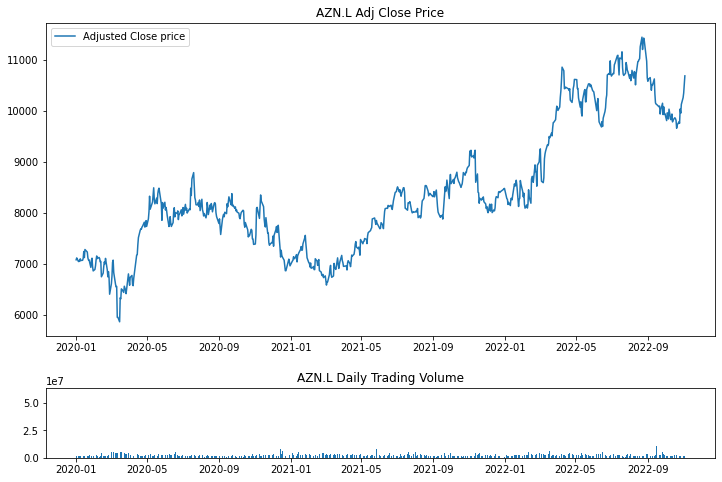

In [35]:
# Plot Adjusted Close price and Volume

top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4) 
top.plot(azn_stock_df.index, azn_stock_df['Adj Close'], label = 'Adjusted Close price') 
plt.title('AZN.L Adj Close Price') 
plt.legend(loc=2) 
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4) 
bottom.bar(azn_stock_df.index, azn_stock_df["Volume"]) 
plt.title('AZN.L Daily Trading Volume') 
plt.gcf().set_size_inches(12,8) 
plt.subplots_adjust(hspace=0.75)

## 6. Merge Stock and Sentiment Dataframes on Date

In [36]:
# Merge data sets on date
merge = azn_stock_df.merge(azn_news_df_combined, how='inner', left_index=True, right_index=True)


In [37]:
# Show merged data set
merge

Open          High           Low    Close     Adj Close  \
Date                                                                     
2020-01-10  7690.0   7717.000000   7608.000000   7645.0   7065.863770    
2020-02-10  7659.0   7710.000000   7610.000000   7710.0   7125.938965    
2020-03-12  6692.0   6778.000000   6314.000000   6314.0   5953.311523    
2020-05-11  8549.0   8719.000000   8522.000000   8707.0   8209.611328    
2020-06-10  8237.0   8444.219727   8170.000000   8404.0   7923.920410    
...            ...           ...           ...      ...           ...    
2022-09-27  9897.0   9995.000000   9795.586914   9923.0   9923.000000    
2022-10-24  9594.0   9823.000000   9594.000000   9782.0   9782.000000    
2022-10-26  9800.0   10038.000000  9789.675781   10034.0  10034.000000   
2022-10-27  10042.0  10100.000000  9899.000000   9951.0   9951.000000    
2022-11-02  10452.0  10560.000000  10424.000000  10520.0  10520.000000   

             Volume  Unnamed: 0 ticker publish_date  \
Date                                                  
2020-01-10  1020795  331         AZN.L  01-10-2020    
2020-02-10  1136979  324         AZN.L  02-10-2020    
2020-03-12  4529777  248         AZN.L  03-12-2020    
2020-05-11  1908220  283         AZN.L  05-11-2020    
2020-06-10  2515293  310         AZN.L  06-10-2020    
...             ...  ...           ...         ...    
2022-09-27  2973886  11          AZN.L  27-09-2022    
2022-10-24  987863   285         AZN.L  24-10-2022    
2022-10-26  3656171  1           AZN.L  26-10-2022    
2022-10-27  1891142  2           AZN.L  27-10-2022    
2022-11-02  1219515  77          AZN.L  11-02-2022    

                                                                                                                                                               title  \
Date                                                                                                                                                                   
2020-01-10  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                                                                                                   
2020-02-10  AstraZeneca's Japanese COVID-19 vaccine trial back up, U.S. still paused By Reuters                                                                        
2020-03-12  UK Stocks-Factors to watch on Dec 3 By Reuters                                                                                                             
2020-05-11  UK Stocks-Factors to watch on Nov 5 By Investing.com                                                                                                       
2020-06-10  EU reviewing Pfizer-BioNTech COVID-19 vaccine in real time By Reuters                                                                                      
...                                                          ...                                                                                                       
2022-09-27  AstraZeneca gets its third regulatory green light in a matter of weeks for asthma drug By Proactive Investors                                              
2022-10-24  AstraZeneca resumes U.S. COVID-19 vaccine trial and next week J&J prepares to do same By Reuters                                                           
2022-10-26  Why AstraZeneca (BIDU) Shares Are Trading Higher Premarket Today? - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)                                      
2022-10-27  AstraZeneca's Ultomiris Showed Zero Relapses In Patients With Chronic Disorder Of Brain, Spinal Cord - AstraZeneca (NASDAQ:AZN), AstraZeneca (OTC:AZNCF)   
2022-11-02  UK pre-market stocks update â€“ British American Tobacco, AstraZeneca, Deliveroo By Investing.com                                                          

                                                                                                                                                       

In [38]:
# Save merged DataFrame

merge.to_csv("/azn_news_stock_merge_20210107.csv", sep=',', encoding='utf-8', header=True)

In [39]:
# Show first row in combined news column

merge['news_combined'].iloc[0]

'Â© Reuters.\n \n UK100 +2.03% Add to/Remove from a Portfolio SHEL +0.77% Add to/Remove from a Portfolio AZN +0.56% Add to/Remove from a Portfolio RR +6.17% Add to/Remove from a Portfolio SN +1.30% Add to/Remove from a Portfolio NG +0.39% Add to/Remove from a Portfolio HBR +1.42% Add to/Remove from a Portfolio DLAR -0.10% Add to/Remove from a Portfolio\n \n Oct 1 (Reuters) - Britain\'s FTSE 100 ( ) index is seen opening 25 points higher at 5,891 on Thursday, according to financial bookmakers, with futures up 0.47% ahead of cash market open.\n \n Smith & Nephew: Medical prosthetics maker Smith & Nephew Plc ( ) expects its decline in underlying revenue in the third quarter of this year, down from almost 30% in the previous three months when it was suffering heavily from the impact of coronavirus lockdowns and a halt in elective procedures.\n \n Rolls-Royce: Britain\'s Rolls-Royce ( ) said it planned to from shareholders, 1 billion pounds from the bond market and secure further loans to r

In [40]:
# Iterate over rows in combined news column

for index, row in merge.iterrows(): 
    print (row["news_combined"])

Â© Reuters.
 
 UK100 +2.03% Add to/Remove from a Portfolio SHEL +0.77% Add to/Remove from a Portfolio AZN +0.56% Add to/Remove from a Portfolio RR +6.17% Add to/Remove from a Portfolio SN +1.30% Add to/Remove from a Portfolio NG +0.39% Add to/Remove from a Portfolio HBR +1.42% Add to/Remove from a Portfolio DLAR -0.10% Add to/Remove from a Portfolio
 
 Oct 1 (Reuters) - Britain's FTSE 100 ( ) index is seen opening 25 points higher at 5,891 on Thursday, according to financial bookmakers, with futures up 0.47% ahead of cash market open.
 
 Smith & Nephew: Medical prosthetics maker Smith & Nephew Plc ( ) expects its decline in underlying revenue in the third quarter of this year, down from almost 30% in the previous three months when it was suffering heavily from the impact of coronavirus lockdowns and a halt in elective procedures.
 
 Rolls-Royce: Britain's Rolls-Royce ( ) said it planned to from shareholders, 1 billion pounds from the bond market and secure further loans to rebuild its 

### Clean data in combined news column

Strip newline escape sequence (\n), unwanted punctuation and backslashes.  

In [41]:
# Create empty list to append cleaned data from combined news column

clean_news = []

for i in range(0, len(merge["news_combined"])): 
    clean_news.append(re.sub("\n", ' ', merge["news_combined"][i]))  # replace n\ with ' '
    clean_news[i] = re.sub(r'[^\w\d\s\']+', '', clean_news[i]) # remove unwanted punctuation and \'


In [42]:
# Show first row in cleaned combined news column

clean_news[0]

"Â Reuters    UK100 203 Add toRemove from a Portfolio SHEL 077 Add toRemove from a Portfolio AZN 056 Add toRemove from a Portfolio RR 617 Add toRemove from a Portfolio SN 130 Add toRemove from a Portfolio NG 039 Add toRemove from a Portfolio HBR 142 Add toRemove from a Portfolio DLAR 010 Add toRemove from a Portfolio    Oct 1 Reuters  Britain's FTSE 100   index is seen opening 25 points higher at 5891 on Thursday according to financial bookmakers with futures up 047 ahead of cash market open    Smith  Nephew Medical prosthetics maker Smith  Nephew Plc   expects its decline in underlying revenue in the third quarter of this year down from almost 30 in the previous three months when it was suffering heavily from the impact of coronavirus lockdowns and a halt in elective procedures    RollsRoyce Britain's RollsRoyce   said it planned to from shareholders 1 billion pounds from the bond market and secure further loans to rebuild its balance sheet after COVID19    Premier Oil Creditors of No

In [43]:
# Add cleaned news column to merged data set

merge['news_cleaned'] = clean_news


merge['news_cleaned'][0]

"Â Reuters    UK100 203 Add toRemove from a Portfolio SHEL 077 Add toRemove from a Portfolio AZN 056 Add toRemove from a Portfolio RR 617 Add toRemove from a Portfolio SN 130 Add toRemove from a Portfolio NG 039 Add toRemove from a Portfolio HBR 142 Add toRemove from a Portfolio DLAR 010 Add toRemove from a Portfolio    Oct 1 Reuters  Britain's FTSE 100   index is seen opening 25 points higher at 5891 on Thursday according to financial bookmakers with futures up 047 ahead of cash market open    Smith  Nephew Medical prosthetics maker Smith  Nephew Plc   expects its decline in underlying revenue in the third quarter of this year down from almost 30 in the previous three months when it was suffering heavily from the impact of coronavirus lockdowns and a halt in elective procedures    RollsRoyce Britain's RollsRoyce   said it planned to from shareholders 1 billion pounds from the bond market and secure further loans to rebuild its balance sheet after COVID19    Premier Oil Creditors of No

In [44]:
# Show head of merged DataFrame

merge.head()

Open         High     Low   Close    Adj Close   Volume  \
Date                                                                    
2020-01-10  7690.0  7717.000000  7608.0  7645.0  7065.863770  1020795   
2020-02-10  7659.0  7710.000000  7610.0  7710.0  7125.938965  1136979   
2020-03-12  6692.0  6778.000000  6314.0  6314.0  5953.311523  4529777   
2020-05-11  8549.0  8719.000000  8522.0  8707.0  8209.611328  1908220   
2020-06-10  8237.0  8444.219727  8170.0  8404.0  7923.920410  2515293   

            Unnamed: 0 ticker publish_date  \
Date                                         
2020-01-10  331         AZN.L  01-10-2020    
2020-02-10  324         AZN.L  02-10-2020    
2020-03-12  248         AZN.L  03-12-2020    
2020-05-11  283         AZN.L  05-11-2020    
2020-06-10  310         AZN.L  06-10-2020    

                                                                                          title  \
Date                                                                                              
2020-01-10  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                              
2020-02-10  AstraZeneca's Japanese COVID-19 vaccine trial back up, U.S. still paused By Reuters   
2020-03-12  UK Stocks-Factors to watch on Dec 3 By Reuters                                        
2020-05-11  UK Stocks-Factors to watch on Nov 5 By Investing.com                                  
2020-06-10  EU reviewing Pfizer-BioNTech COVID-19 vaccine in real time By Reuters                 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [46]:
# Save merged DataFrame

merge.to_csv("/azn__merge_cleaned_20210107.csv", sep=',', encoding='utf-8', header=True)

## 7. Sentiment Analysis

TextBlob will be used to get subjectivity and polarity scores for the cleaned and merged news data. Polarity is a float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgement whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1] where 0 is objective and 1 is subjective.

In [48]:
# Create function to get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [49]:
# Create new columns
merge['subjectivity'] = merge['news_cleaned'].apply(getSubjectivity)
merge['polarity'] = merge['news_cleaned'].apply(getPolarity)

In [50]:
# Show new columns
merge.head(3)

Open    High     Low   Close    Adj Close   Volume  Unnamed: 0  \
Date                                                                           
2020-01-10  7690.0  7717.0  7608.0  7645.0  7065.863770  1020795  331          
2020-02-10  7659.0  7710.0  7610.0  7710.0  7125.938965  1136979  324          
2020-03-12  6692.0  6778.0  6314.0  6314.0  5953.311523  4529777  248          

           ticker publish_date  \
Date                             
2020-01-10  AZN.L  01-10-2020    
2020-02-10  AZN.L  02-10-2020    
2020-03-12  AZN.L  03-12-2020    

                                                                                          title  \
Date                                                                                              
2020-01-10  UPDATE 1-UK Stocks-Factors to watch on Oct. 1 By Reuters                              
2020-02-10  AstraZeneca's Japanese COVID-19 vaccine trial back up, U.S. still paused By Reuters   
2020-03-12  UK Stocks-Factors to watch on Dec 3 By Reuters                                        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   body_text  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [51]:
# Show shape of DataFrame
merge.shape

(146, 20)

In [52]:
# Save DataFrame with subjectivity and polarity scores
merge.to_csv("/azn__merge_cleaned_subj_pol_20210107.csv", sep=',', encoding='utf-8', header=True)

## 9. Feature engineering

We will calculate whether the next day Adjusted Close price increased/held or decreased and label these as 1 and 0 respectively to build and train machine learning classifier models to predict price direction based on sentiment.

In [54]:
# Create copy of stock data

azn_stock_df_label = azn_stock_df.copy()
azn_stock_df_label

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,7595.0,7670.0,7565.000000,7660.0,7079.726562,1704325
2020-01-03,7625.0,7700.0,7580.919922,7700.0,7116.696289,1090818
2020-01-06,7669.0,7680.0,7546.000000,7623.0,7045.529785,1348181
2020-01-07,7608.0,7665.0,7563.000000,7645.0,7065.863770,1308820
2020-01-08,7617.0,7669.0,7579.000000,7626.0,7048.302734,1256533
...,...,...,...,...,...,...
2022-10-28,9950.0,10134.0,9940.320312,10124.0,10124.000000,1111337
2022-10-31,10130.0,10318.0,10034.000000,10254.0,10254.000000,1745228
2022-11-01,10286.0,10436.0,10286.000000,10346.0,10346.000000,1360768


In [55]:
# "1" when AZN Adj Close value rose or stayed as the same;
# "0" when AZN Adj Close value decreased.

azn_stock_df_label['Adj Close Next'] = azn_stock_df_label['Adj Close'].shift(-1)
azn_stock_df_label['Label'] = azn_stock_df_label.apply(lambda x: 1 if (x['Adj Close Next']>= x['Adj Close']) else 0, axis =1)

azn_stock_df_label[['Adj Close', 'Adj Close Next', 'Label']].head(5)

,Adj Close,Adj Close Next,Label
Date,,,
2020-01-02,7079.726562,7116.696289,1
2020-01-03,7116.696289,7045.529785,0
2020-01-06,7045.529785,7065.863770,1
2020-01-07,7065.863770,7048.302734,0
2020-01-08,7048.302734,7099.136230,1


In [56]:
# Save DataFrame

azn_stock_df_label.to_pickle("/azn_stock_df_labels_20210107.pkl")

In [57]:
azn_stock_df_label.to_csv("/azn_stock_df_label_20210107.csv", sep=',', encoding='utf-8', header=True)

In [58]:
# Show Adj Close Next and Label with Date

azn_stock_df_label_adj_nxt = azn_stock_df_label[['Adj Close Next', 'Label']]
azn_stock_df_label_adj_nxt

,Adj Close Next,Label
Date,,
2020-01-02,7116.696289,1
2020-01-03,7045.529785,0
2020-01-06,7065.863770,1
2020-01-07,7048.302734,0
2020-01-08,7099.136230,1
...,...,...
2022-10-28,10254.000000,1
2022-10-31,10346.000000,1
2022-11-01,10520.000000,1


In [59]:
# Drop NaN row

azn_stock_df_label_adj_nxt = azn_stock_df_label_adj_nxt.dropna()
azn_stock_df_label_adj_nxt

,Adj Close Next,Label
Date,,
2020-01-02,7116.696289,1
2020-01-03,7045.529785,0
2020-01-06,7065.863770,1
2020-01-07,7048.302734,0
2020-01-08,7099.136230,1
...,...,...
2022-10-27,10124.000000,1
2022-10-28,10254.000000,1
2022-10-31,10346.000000,1


In [60]:
# Merge DataFrames on date
merge2 = azn_stock_df.merge(azn_stock_df_label_adj_nxt, how='inner', left_index=True, right_index=True)

In [61]:
# Drop NaN row and show merged DataFrame
merge2 = merge2.dropna()
merge2

,Open,High,Low,Close,Adj Close,Volume,Adj Close Next,Label
Date,,,,,,,,
2020-01-02,7595.0,7670.0,7565.000000,7660.0,7079.726562,1704325,7116.696289,1
2020-01-03,7625.0,7700.0,7580.919922,7700.0,7116.696289,1090818,7045.529785,0
2020-01-06,7669.0,7680.0,7546.000000,7623.0,7045.529785,1348181,7065.863770,1
2020-01-07,7608.0,7665.0,7563.000000,7645.0,7065.863770,1308820,7048.302734,0
2020-01-08,7617.0,7669.0,7579.000000,7626.0,7048.302734,1256533,7099.136230,1
...,...,...,...,...,...,...,...,...
2022-10-27,10042.0,10100.0,9899.000000,9951.0,9951.000000,1891142,10124.000000,1
2022-10-28,9950.0,10134.0,9940.320312,10124.0,10124.000000,1111337,10254.000000,1
2022-10-31,10130.0,10318.0,10034.000000,10254.0,10254.000000,1745228,10346.000000,1


In [62]:
# Save DataFrame
merge2.to_csv("/azn_prices_labels_20210107.csv", sep=',', encoding='utf-8', header=True)

In [63]:
merge2.to_pickle("/azn_prices_labels_20210107.pkl")

In [64]:
# Merge next day Adjusted Close price and Label with combined stock data and sentiment DataFrame

merge3 = azn_stock_df_label_adj_nxt.merge(merge, how='inner', left_index=True, right_index=True)
merge3

Adj Close Next  Label     Open          High           Low  \
Date                                                                     
2020-01-10  7070.484375     1      7690.0   7717.000000   7608.000000    
2020-02-10  7105.605957     0      7659.0   7710.000000   7610.000000    
2020-03-12  5955.197266     1      6692.0   6778.000000   6314.000000    
2020-05-11  8350.098633     1      8549.0   8719.000000   8522.000000    
2020-06-10  7803.232422     0      8237.0   8444.219727   8170.000000    
...                 ...    ..         ...           ...           ...    
2022-09-27  10076.000000    1      9897.0   9995.000000   9795.586914    
2022-10-24  9753.000000     0      9594.0   9823.000000   9594.000000    
2022-10-26  9951.000000     0      9800.0   10038.000000  9789.675781    
2022-10-27  10124.000000    1      10042.0  10100.000000  9899.000000    
2022-11-02  10682.000000    1      10452.0  10560.000000  10424.000000   

              Close     Adj Close   Volume  Unnamed: 0 ticker  ...  \
Date                                                           ...   
2020-01-10  7645.0   7065.863770   1020795  331         AZN.L  ...   
2020-02-10  7710.0   7125.938965   1136979  324         AZN.L  ...   
2020-03-12  6314.0   5953.311523   4529777  248         AZN.L  ...   
2020-05-11  8707.0   8209.611328   1908220  283         AZN.L  ...   
2020-06-10  8404.0   7923.920410   2515293  310         AZN.L  ...   
...            ...           ...       ...  ...           ...  ...   
2022-09-27  9923.0   9923.000000   2973886  11          AZN.L  ...   
2022-10-24  9782.0   9782.000000   987863   285         AZN.L  ...   
2022-10-26  10034.0  10034.000000  3656171  1           AZN.L  ...   
2022-10-27  9951.0   9951.000000   1891142  2           AZN.L  ...   
2022-11-02  10520.0  10520.000000  1219515  77          AZN.L  ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [65]:
# Save merged DataFrame

merge3.to_csv("/azn_prices_labels_news_20210107.csv", sep=',', encoding='utf-8', header=True)

In [66]:
merge3.to_pickle("/azn_prices_labels_news_20210107.pkl")

In [67]:
merge3 = pd.read_pickle("/azn_prices_labels_news_20210107.pkl")

In [68]:
# Collapse data set to keep relevant stock price and sentiment score columns only

keep_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'subjectivity', 'polarity', 'compound', 'neg',	'neu',	'pos', 'Label']
df =  merge3[keep_columns]
df

,Open,High,Low,Close,Adj Close,Volume,subjectivity,polarity,compound,neg,neu,pos,Label
Date,,,,,,,,,,,,,
2020-01-10,7690.0,7717.000000,7608.000000,7645.0,7065.863770,1020795,0.381333,0.045438,-0.9274,0.073,0.900,0.027,1
2020-02-10,7659.0,7710.000000,7610.000000,7710.0,7125.938965,1136979,0.335507,0.077174,0.7218,0.058,0.872,0.070,0
2020-03-12,6692.0,6778.000000,6314.000000,6314.0,5953.311523,4529777,0.539865,0.118784,-0.3612,0.055,0.900,0.045,1
2020-05-11,8549.0,8719.000000,8522.000000,8707.0,8209.611328,1908220,0.425210,0.096054,0.9566,0.028,0.895,0.077,1
2020-06-10,8237.0,8444.219727,8170.000000,8404.0,7923.920410,2515293,0.321625,0.080579,0.6486,0.000,0.965,0.035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27,9897.0,9995.000000,9795.586914,9923.0,9923.000000,2973886,0.515278,0.160516,0.6682,0.059,0.847,0.094,1
2022-10-24,9594.0,9823.000000,9594.000000,9782.0,9782.000000,987863,0.390848,0.028757,0.9268,0.040,0.897,0.063,0
2022-10-26,9800.0,10038.000000,9789.675781,10034.0,10034.000000,3656171,0.521307,0.187784,-0.2263,0.304,0.497,0.199,0


## 10. Modelling

Split the data in feature matrix (X) and target vector (y).


In [69]:
# Create feature data set
X = df
X = np.array(X.drop(['Label'], 1))

# Create target data set
y = np.array(df['Label'])

We will split the data into train and test sets to verify predictions. Time series data cannot be split randomly as this would introduce look-ahead bias so the first 80% will be the training set and the last 20% the test set.

In [70]:
# Split data into 80% training and 20% testing data sets

split = int(0.8*len(df))

In [71]:
X_train = X[0:split]
y_train = y[0:split]

X_test = X[split:]
y_test = y[split:]

In [72]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(116, 12)
(116,)
(30, 12)
(30,)


In [73]:
# Create and train the model
model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [74]:
# Show model's predictions
predictions = model.predict(X_test)
predictions

array([0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1])

In [75]:
# Show actual values
y_test

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1])

In [76]:
# Show model metrics 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.35      0.44        17
           1       0.45      0.69      0.55        13

    accuracy                           0.50        30
   macro avg       0.53      0.52      0.49        30
weighted avg       0.54      0.50      0.49        30

